NOTE: this wont run properly if run with llama_index versions lower than 11 (becaus of triplet parser function)

In [1]:
#!pip install llama-index-llms-ollama

In [2]:
from groq import Groq
from llama_index.core import Settings, ServiceContext, StorageContext, SimpleDirectoryReader
from llama_index.llms.groq import Groq as Groq_llamaindex
#from llama_index.llms.ollama import Ollama as Ollama_llamaindex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
#from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import VectorStoreIndex
from llama_index.graph_stores.neo4j import Neo4jGraphStore, Neo4jPropertyGraphStore
from milvus import default_server
from dotenv import load_dotenv
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor, SimpleLLMPathExtractor, ImplicitPathExtractor, DynamicLLMPathExtractor
from llama_index.core import Document

from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)



load_dotenv()
import json
import os
import numpy as np


# Retrieve API keys and credentials securely
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_URL = os.getenv('NEO4J_URL', 'bolt://localhost:7687')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE', 'neo4j')


#client = Groq(api_key = GROQ_API_KEY)

llm = Groq_llamaindex(model="llama3-groq-70b-8192-tool-use-preview",
                       api_key='your api key', #using data uploader for now
                       temperature=0)

#llm = Ollama_llamaindex(model='mistral:instruct', temperature=0)

Settings.llm = llm
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

StorageContext.llm = llm
ServiceContext.llm = llm

/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/nzta_dev_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
username = NEO4J_USERNAME
password =  NEO4J_PASSWORD
url = NEO4J_URL
database = NEO4J_DATABASE



In [4]:
password

'nzta_neo4j'

In [5]:

property_graph_store = Neo4jPropertyGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
    refresh_schema=True,
)
storage_context = StorageContext.from_defaults(property_graph_store=property_graph_store)



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [6]:
property_graph_store.get_schema(refresh=True)

refreshing schema


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


{'node_props': {'Chunk': [{'property': 'creation_date',
    'type': 'STRING',
    'values': ['2024-10-23'],
    'distinct_count': 1},
   {'property': 'file_type',
    'type': 'STRING',
    'values': ['text/plain'],
    'distinct_count': 1},
   {'property': 'last_modified_date',
    'type': 'STRING',
    'values': ['2024-10-23'],
    'distinct_count': 1},
   {'property': 'embedding', 'type': 'LIST', 'max_size': 384, 'min_size': 384},
   {'property': 'file_path',
    'type': 'STRING',
    'values': ['/Users/felipenavarro/Documents/Auckland/nzta/nzta_'],
    'distinct_count': 1},
   {'property': 'file_name',
    'type': 'STRING',
    'values': ['first_hops_New_Zealand_Transport_Agency.txt',
     'first_hops_Road_Safety_Initiatives.txt',
     'first_hops_Public_Transport_Projects.txt',
     'first_hops_Vehicle_Registration_and_Licensing.txt',
     'first_hops_Infrastructure_Development.txt',
     'first_hops_Cycling_and_Walking_Networks.txt',
     'first_hops_Freight_and_Logistics.txt',
  

In [6]:
# print working dir

print(os.getcwd())

/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG


In [13]:
# load hotpotQA/hotpot_train_v1.1.json 
with open("sp_cot_data/newzealand transport agency and newzealand transport related topics (road, projects, safety, vehicles, personel, organization, etc)_100.json", 'r') as file:
    data = json.load(file)

len(data)

2

In [14]:
data['second_hops']

{'New Zealand': {'term': 'New Zealand',
  'passage': "### Transport in New Zealand\n\nTransport in New Zealand encompasses a diverse range of modes and infrastructure that facilitate the movement of people and goods across the country’s varied landscapes. The transport system is characterized by its reliance on road and air travel, with significant contributions from rail and maritime transport. #### Road Transport\n\nRoad transport is the most widely used mode of transport in New Zealand, accounting for the majority of passenger and freight movement. The country has an extensive network of roads, including approximately 94,000 kilometers of public roads, with a mix of urban and rural routes. The State Highway network, managed by Waka Kotahi NZ Transport Agency, consists of around 11,000 kilometers of key routes that connect major cities and regions. The road system is vital for economic activity, enabling access to remote areas and supporting the tourism industry. #### Rail Transport\

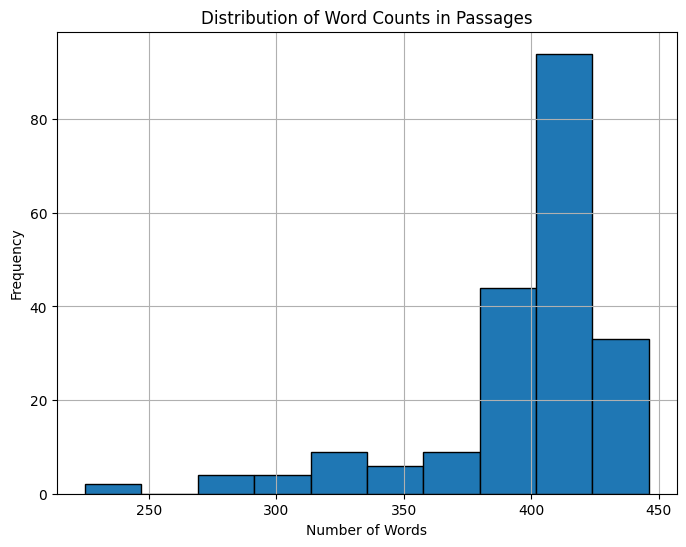

In [15]:
import matplotlib.pyplot as plt


# Extract passages from both 'first_hops' and 'second_hops'
passages = []

# Retrieve passages from first_hops
for entity, info in data.get('first_hops', {}).items():
    passages.append(info['passage'])

# Retrieve passages from second_hops
for entity, info in data.get('second_hops', {}).items():
    passages.append(info['passage'])

# Count the number of words in each passage
word_counts = [len(passage.split()) for passage in passages]

# Plotting the histogram of word counts
plt.figure(figsize=(8, 6))
plt.hist(word_counts, bins=10, edgecolor='black')
plt.title('Distribution of Word Counts in Passages')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [16]:
len(passages)

205

In [17]:
import os
import csv
import re
import signal
import sys
import time
from llama_index.core import PropertyGraphIndex
from llama_index.core.indices.property_graph import SimpleLLMPathExtractor
from llama_index.core import SimpleDirectoryReader
import nest_asyncio

nest_asyncio.apply()

# Constants
PROCESSED_FILE = 'processed_passages.csv'
TEMP_DIR = 'temp_passages'

# Initialize processed pairs set
processed_pairs = set()

# Sanitize filenames by replacing non-alphanumeric characters with underscores
sanitize_filename = lambda name: re.sub(r'[^a-zA-Z0-9_\-]', '_', name)

# Generate a unique filename with optional integer suffix
def generate_unique_filename(hop_type, term, directory, extension='txt'):
    base_name = f"{sanitize_filename(hop_type)}_{sanitize_filename(term)}"
    file_path = os.path.join(directory, f"{base_name}.{extension}")
    counter = 1
    while os.path.exists(file_path):
        file_path = os.path.join(directory, f"{base_name}_{counter}.{extension}")
        counter += 1
    return file_path

# Load processed pairs from CSV
def load_processed_pairs(file_path):
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                processed_pairs.update(tuple(row[:2]) for row in reader if len(row) >= 2)
            print(f"Loaded {len(processed_pairs)} processed pairs from '{file_path}'.")
        except Exception as e:
            print(f"Error loading processed pairs: {e}")
    else:
        print(f"No existing processed file found at '{file_path}'. Starting fresh.")

# Append a processed pair to CSV
def append_processed_pair(writer, hop_type, term):
    try:
        writer.writerow([hop_type, term])
        writer.flush()
        os.fsync(writer.fileno())
        processed_pairs.add((hop_type, term))
        print(f"Recorded pair: Hop Type='{hop_type}', Term='{term}'")
    except Exception as e:
        print(f"Error recording pair ({hop_type}, {term}): {e}")

# Signal handler for graceful shutdown
def signal_handler(sig, frame):
    print('Interrupt received. Exiting...')
    sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)
signal.signal(signal.SIGTERM, signal_handler)

# Ensure temp directory exists
os.makedirs(TEMP_DIR, exist_ok=True)

# Load already processed pairs
load_processed_pairs(PROCESSED_FILE)

# Open the processed file in append mode
try:
    processed_file = open(PROCESSED_FILE, 'a', newline='', encoding='utf-8', buffering=1)
    csv_writer = csv.writer(processed_file)
except Exception as e:
    print(f"Failed to open '{PROCESSED_FILE}' for appending: {e}")
    sys.exit(1)

# Helper function to process and save passages
def process_passages(hop_type, data):
    for term, info in data.items():
        if (hop_type, term) in processed_pairs:
            print(f"Skipping already processed pair: Hop Type={hop_type}, Term={term}")
            continue

        passage = info.get('passage')
        if not passage:
            print(f"No passage found for term '{term}'. Skipping.")
            continue

        # Ensure only one file in temp directory
        for existing_file in os.listdir(TEMP_DIR):
            existing_path = os.path.join(TEMP_DIR, existing_file)
            os.remove(existing_path)
            print(f"Removed existing file '{existing_path}' from temp directory.")

        # Generate unique filename and save passage
        temp_file_path = generate_unique_filename(hop_type, term, TEMP_DIR)
        try:
            with open(temp_file_path, 'w', encoding='utf-8') as file:
                file.write(passage)
            print(f"Saved passage for term '{term}' to '{temp_file_path}'.")
        except Exception as e:
            print(f"Error writing passage for term '{term}' to '{temp_file_path}': {e}")
            continue

        # Process the passage
        try:
            graph_documents = SimpleDirectoryReader(TEMP_DIR).load_data()
            graph_index = PropertyGraphIndex.from_documents(
                graph_documents,
                property_graph_store=property_graph_store,  # Ensure these are defined
                storage_context=storage_context,            # Ensure these are defined
                kg_extractors=[SimpleLLMPathExtractor(llm=llm)],  # Ensure llm is defined
                embed_kg_nodes=True,
                show_progress=True
            )
            print(f"Processed term '{term}' with hop type '{hop_type}'.")
            time.sleep(20)  # Pause as required
        except Exception as e:
            print(f"Error processing term '{term}': {e}")
            continue
        finally:
            # Remove the temp file after processing
            try:
                os.remove(temp_file_path)
                print(f"Removed temp file '{temp_file_path}'.")
            except Exception as e:
                print(f"Error removing temp file '{temp_file_path}': {e}")

        # Record the processed pair
        append_processed_pair(csv_writer, hop_type, term)

# Example 'data' structure (Define these variables appropriately)
# data = {
#     'first_hops': {
#         'New_Zealand_Transport_Agency': {'passage': 'Sample passage for NZ Transport Agency'},
#         'Road_Safety_Initiatives': {'passage': 'Sample passage for Road Safety Initiatives'},
#         'Public_Transport_Projects': {'passage': 'Sample passage for Public Transport Projects'},
#         'Vehicle_Registration_and_Licensing': {'passage': 'Sample passage for Vehicle Registration and Licensing'},
#         'Infrastructure_Development': {'passage': 'Sample passage for Infrastructure Development'},
#     },
#     'second_hops': {
#         # Add second_hops data here
#     }
# }

# Process passages for each hop type
process_passages('first_hops', data.get('first_hops', {}))
process_passages('second_hops', data.get('second_hops', {}))

# Close the processed file
try:
    processed_file.close()
    print(f"All processed pairs have been recorded to '{PROCESSED_FILE}'.")
except Exception as e:
    print(f"Error closing '{PROCESSED_FILE}': {e}")


Loaded 198 processed pairs from 'processed_passages.csv'.
Skipping already processed pair: Hop Type=first_hops, Term=Transport Projects
Skipping already processed pair: Hop Type=first_hops, Term=Road Safety Initiatives
Skipping already processed pair: Hop Type=first_hops, Term=Public Transport Development
Skipping already processed pair: Hop Type=first_hops, Term=Vehicle Emissions Regulations
Skipping already processed pair: Hop Type=first_hops, Term=Cycling Infrastructure
Skipping already processed pair: Hop Type=first_hops, Term=Freight and Logistics Management
Skipping already processed pair: Hop Type=first_hops, Term=Transport Policy and Planning
Skipping already processed pair: Hop Type=first_hops, Term=Infrastructure Funding
Skipping already processed pair: Hop Type=first_hops, Term=Traffic Management Systems
Skipping already processed pair: Hop Type=first_hops, Term=Driver Licensing Programs
Skipping already processed pair: Hop Type=first_hops, Term=Road Maintenance Strategies
S

Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 Vissim ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_VISSIM.txt', 'file_name': 'second_hops_VISSIM.txt', 'file_type': 'text/plain', 'file_size': 2506, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': '905341cf-967b-4824-aa50-610227079d08'})
this is kg_rel 0 {'label': 'Is', 'source_id': 'Vissim', 'target_id': 'Microscopic traffic simulation software', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_VISSIM.txt', 'file_name': 'second_hops_VISSIM.txt', 'file_type': 'text/plain', 'file_size': 2506, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': '905341cf-967b-4824-aa50-610227079d08'}}
this is kg_rel 0

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]
Generating embeddings: 0it [00:00, ?it/s]


This is an example of a kg relation to be embedded
Vissim Is Microscopic traffic simulation software {}


Generating embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'VISSIM' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_VISSIM.txt'.
Error recording pair (second_hops, VISSIM): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'Auckland's Northern Busway.' to 'temp_passages/second_hops_Auckland_s_Northern_Busway_.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 Northern busway ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Auckland_s_Northern_Busway_.txt', 'file_name': 'second_hops_Auckland_s_Northern_Busway_.txt', 'file_type': 'text/plain', 'file_size': 2338, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': 'fb927e8e-083c-4bc6-b3a2-e768b8f9569e'})
this is kg_rel 0 {'label': 'Is', 'source_id': 'Northern busway', 'target_id': 'Dedicated bus rapid transit corridor', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Auckland_s_Northern_Busway_.txt', 'file_name': 'second_hops_Auckland_s_Northern_Busway_.txt', 'file_type': 'text/plain', 'file_size': 2338, 'creation_date': '2024-10-24', 'last_modified_

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


This is an example of a kg relation to be embedded
Northern busway Is Dedicated bus rapid transit corridor {}


Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'Auckland's Northern Busway.' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_Auckland_s_Northern_Busway_.txt'.
Error recording pair (second_hops, Auckland's Northern Busway.): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'Auckland Ferry Network' to 'temp_passages/second_hops_Auckland_Ferry_Network.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 Auckland ferry network ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Auckland_Ferry_Network.txt', 'file_name': 'second_hops_Auckland_Ferry_Network.txt', 'file_type': 'text/plain', 'file_size': 2873, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': 'ea05b5a8-6211-4080-9f13-4a5bfc64475c'})
this is kg_rel 0 {'label': 'Is', 'source_id': 'Auckland ferry network', 'target_id': 'Vital component of public transport system', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Auckland_Ferry_Network.txt', 'file_name': 'second_hops_Auckland_Ferry_Network.txt', 'file_type': 'text/plain', 'file_size': 2873, 'creation_date': '2024-10-24', 'last_modified_

Generating embeddings: 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]


This is an example of a kg relation to be embedded
Auckland ferry network Is Vital component of public transport system {}


Generating embeddings: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'Auckland Ferry Network' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_Auckland_Ferry_Network.txt'.
Error recording pair (second_hops, Auckland Ferry Network): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'Auckland.' to 'temp_passages/second_hops_Auckland_.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 Auckland ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Auckland_.txt', 'file_name': 'second_hops_Auckland_.txt', 'file_type': 'text/plain', 'file_size': 2971, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': 'b3877182-e74b-4c64-ae4a-8463f228f9cb'})
this is kg_rel 0 {'label': 'Is', 'source_id': 'Auckland', 'target_id': 'Critical hub for transport', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Auckland_.txt', 'file_name': 'second_hops_Auckland_.txt', 'file_type': 'text/plain', 'file_size': 2971, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': 'b3877182-e74b-4c64-ae4a-8463f228f9cb'}}
this is kg_re

Generating embeddings: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


This is an example of a kg relation to be embedded
Auckland Is Critical hub for transport {}


Generating embeddings: 100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'Auckland.' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_Auckland_.txt'.
Error recording pair (second_hops, Auckland.): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'New Zealand Police.' to 'temp_passages/second_hops_New_Zealand_Police_.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 New zealand police ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_New_Zealand_Police_.txt', 'file_name': 'second_hops_New_Zealand_Police_.txt', 'file_type': 'text/plain', 'file_size': 2799, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': '75c0732c-2ad9-4c52-8529-5dd358a56152'})
this is kg_rel 0 {'label': 'Is', 'source_id': 'New zealand police', 'target_id': 'National law enforcement agency', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_New_Zealand_Police_.txt', 'file_name': 'second_hops_New_Zealand_Police_.txt', 'file_type': 'text/plain', 'file_size': 2799, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_s

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


This is an example of a kg relation to be embedded
New zealand police Is National law enforcement agency {}


Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'New Zealand Police.' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_New_Zealand_Police_.txt'.
Error recording pair (second_hops, New Zealand Police.): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'ESC' to 'temp_passages/second_hops_ESC.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 Electric scooters ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_ESC.txt', 'file_name': 'second_hops_ESC.txt', 'file_type': 'text/plain', 'file_size': 2950, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': 'c3107242-d1c7-43e0-8a0c-e14db81c964f'})
this is kg_rel 0 {'label': 'Classified as', 'source_id': 'Electric scooters', 'target_id': 'Mobility devices', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_ESC.txt', 'file_name': 'second_hops_ESC.txt', 'file_type': 'text/plain', 'file_size': 2950, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': 'c3107242-d1c7-43e0-8a0c-e14db81c964f'}}
this is kg_rel 0 s

Generating embeddings: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


This is an example of a kg relation to be embedded
Electric scooters Classified as Mobility devices {}


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'ESC' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_ESC.txt'.
Error recording pair (second_hops, ESC): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'Health and Safety at Work Act 2015' to 'temp_passages/second_hops_Health_and_Safety_at_Work_Act_2015.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

calling achat


Extracting paths from text: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


changes are being registered
this is a node beofre poping the KG_NODES_KEY nodes and KG_RELATIONS_KEY relations
this is the node part
this is the relation part
this is kg_node 0 Health and safety at work act 2015 ({'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Health_and_Safety_at_Work_Act_2015.txt', 'file_name': 'second_hops_Health_and_Safety_at_Work_Act_2015.txt', 'file_type': 'text/plain', 'file_size': 2678, 'creation_date': '2024-10-24', 'last_modified_date': '2024-10-24', 'triplet_source_id': '9635f95e-2f41-4962-91c8-e58f274706e6'})
this is kg_rel 0 {'label': 'Is', 'source_id': 'Health and safety at work act 2015', 'target_id': 'Key piece of legislation', 'properties': {'file_path': '/Users/felipenavarro/Documents/Auckland/nzta/nzta_dev/NZTA-GraphRAG/temp_passages/second_hops_Health_and_Safety_at_Work_Act_2015.txt', 'file_name': 'second_hops_Health_and_Safety_at_Work_Act_2015.txt', 'file_type': 'text/plain', 'file_size'

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


This is an example of a kg relation to be embedded
Health and safety at work act 2015 Is Key piece of legislation {}


Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


I have succesuflly created relation embeddings
inserting nodes
inserting kg nodes
inserting relations
updating schema
done updating schema
Processed term 'Health and Safety at Work Act 2015' with hop type 'second_hops'.
Removed temp file 'temp_passages/second_hops_Health_and_Safety_at_Work_Act_2015.txt'.
Error recording pair (second_hops, Health and Safety at Work Act 2015): '_csv.writer' object has no attribute 'flush'
All processed pairs have been recorded to 'processed_passages.csv'.


In [55]:
from neo4j import GraphDatabase

# Function to create a connection to the Neo4j database
def connect_to_neo4j(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    return driver

# Function to retrieve nodes with label "Chunk" that have no incoming or outgoing relations
def get_isolated_chunks(driver):
    query = """
    MATCH (n:Chunk)
    WHERE NOT (n)--()
    RETURN n.file_name AS file_name
    """
    
    file_names = []
    with driver.session() as session:
        result = session.run(query)
        for record in result:
            file_names.append(record['file_name'])
    
    return file_names

uri = NEO4J_URL
user = NEO4J_USERNAME
password = NEO4J_PASSWORD

driver = connect_to_neo4j(uri, user, password)

# Retrieve file names of isolated "Chunk" nodes
file_names = get_isolated_chunks(driver)

# Close the connection
driver.close()

# Print or use the file names as needed
print(file_names)


['first_hops_New_Zealand_Transport_Agency.txt', 'first_hops_New_Zealand_Transport_Agency.txt', 'first_hops_Road_Safety_Initiatives.txt', 'first_hops_New_Zealand_Transport_Agency.txt', 'first_hops_Road_Safety_Initiatives.txt', 'first_hops_New_Zealand_Transport_Agency.txt', 'first_hops_Public_Transport_Projects.txt', 'first_hops_Road_Safety_Initiatives.txt', 'first_hops_Vehicle_Registration_and_Licensing.txt', 'first_hops_Infrastructure_Development.txt', 'first_hops_New_Zealand_Transport_Agency.txt', 'first_hops_Public_Transport_Projects.txt', 'first_hops_Road_Safety_Initiatives.txt', 'first_hops_Vehicle_Registration_and_Licensing.txt', 'first_hops_Cycling_and_Walking_Networks.txt', 'first_hops_Infrastructure_Development.txt', 'first_hops_New_Zealand_Transport_Agency.txt', 'first_hops_Public_Transport_Projects.txt', 'first_hops_Road_Safety_Initiatives.txt', 'first_hops_Vehicle_Registration_and_Licensing.txt', 'first_hops_Cycling_and_Walking_Networks.txt', 'first_hops_Freight_and_Logistic

In [56]:
# Function to extract hop type and id from the file name
def extract_hop_type_and_id(file_name):
    # Assuming the file name format is hop_type_id_something.txt
    match = re.match(r"(\w+)_(\w+)_.*\.txt", file_name)
    if match:
        hop_type = match.group(1)  # e.g., first_hops, second_hops
        hop_id = match.group(2)    # e.g., NZTA, some other term
        return hop_type, hop_id
    return None, None
# Function to remove nodes based on hop_type and id
def remove_nodes_from_neo4j(driver, files_to_redo):
    with driver.session() as session:
        for file_name in files_to_redo:
            hop_type, hop_id = extract_hop_type_and_id(file_name)
            if hop_type and hop_id:
                # Assuming your nodes have a 'file_name' property for identification
                query = """
                MATCH (n:Chunk {file_name: $file_name})
                DETACH DELETE n
                """
                session.run(query, file_name=file_name)
                print(f"Removed node with file_name '{file_name}' from the database.")

# Remove the nodes from Neo4j
remove_nodes_from_neo4j(driver, file_names)



/var/folders/zm/7jdzrt5j23gbgc__xf01_jwr0000gn/T/ipykernel_45590/1295387119.py:12: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Removed node with file_name 'first_hops_New_Zealand_Transport_Agency.txt' from the database.
Removed node with file_name 'first_hops_New_Zealand_Transport_Agency.txt' from the database.
Removed node with file_name 'first_hops_Road_Safety_Initiatives.txt' from the database.
Removed node with file_name 'first_hops_New_Zealand_Transport_Agency.txt' from the database.
Removed node with file_name 'first_hops_Road_Safety_Initiatives.txt' from the database.
Removed node with file_name 'first_hops_New_Zealand_Transport_Agency.txt' from the database.
Removed node with file_name 'first_hops_Public_Transport_Projects.txt' from the database.
Removed node with file_name 'first_hops_Road_Safety_Initiatives.txt' from the database.
Removed node with file_name 'first_hops_Vehicle_Registration_and_Licensing.txt' from the database.
Removed node with file_name 'first_hops_Infrastructure_Development.txt' from the database.
Removed node with file_name 'first_hops_New_Zealand_Transport_Agency.txt' from the d

In [57]:
file_names

['first_hops_New_Zealand_Transport_Agency.txt',
 'first_hops_New_Zealand_Transport_Agency.txt',
 'first_hops_Road_Safety_Initiatives.txt',
 'first_hops_New_Zealand_Transport_Agency.txt',
 'first_hops_Road_Safety_Initiatives.txt',
 'first_hops_New_Zealand_Transport_Agency.txt',
 'first_hops_Public_Transport_Projects.txt',
 'first_hops_Road_Safety_Initiatives.txt',
 'first_hops_Vehicle_Registration_and_Licensing.txt',
 'first_hops_Infrastructure_Development.txt',
 'first_hops_New_Zealand_Transport_Agency.txt',
 'first_hops_Public_Transport_Projects.txt',
 'first_hops_Road_Safety_Initiatives.txt',
 'first_hops_Vehicle_Registration_and_Licensing.txt',
 'first_hops_Cycling_and_Walking_Networks.txt',
 'first_hops_Infrastructure_Development.txt',
 'first_hops_New_Zealand_Transport_Agency.txt',
 'first_hops_Public_Transport_Projects.txt',
 'first_hops_Road_Safety_Initiatives.txt',
 'first_hops_Vehicle_Registration_and_Licensing.txt',
 'first_hops_Cycling_and_Walking_Networks.txt',
 'first_hops

In [58]:
file_names_copy = file_names.copy()

In [59]:
import os
import csv
import re
import shutil
import signal
import sys
import time
from typing import List

from llama_index.core import PropertyGraphIndex
from llama_index.core.indices.property_graph import SimpleLLMPathExtractor
from llama_index.core import SimpleDirectoryReader
import nest_asyncio

# Apply nest_asyncio to allow nested event loops (useful in certain environments)
nest_asyncio.apply()

# Define the path for the processed questions and paragraphs file
PROCESSED_FILE = 'processed_passages.csv'

# Initialize a set to store processed (hop_type, term) pairs
processed_pairs = set()

# Function to sanitize filenames by replacing non-alphanumeric characters with underscores
def sanitize_filename(name: str) -> str:
    return re.sub(r'[^a-zA-Z0-9_\-]', '_', name)

# Function to generate a unique filename with optional integer suffix
def generate_unique_filename(hop_type: str, term: str, directory: str, extension: str = 'txt') -> str:
    sanitized_hop = sanitize_filename(hop_type)
    sanitized_term = sanitize_filename(term)
    base_name = f"{sanitized_hop}_{sanitized_term}"
    file_name = f"{base_name}.{extension}"
    file_path = os.path.join(directory, file_name)
    
    counter = 1
    while os.path.exists(file_path):
        file_name = f"{base_name}_{counter}.{extension}"
        file_path = os.path.join(directory, file_name)
        counter += 1
    
    return file_path

# Function to load processed pairs from the CSV file
def load_processed_pairs(file_path: str):
    if os.path.exists(file_path):
        try:
            with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    if len(row) >= 2:
                        hop_type, term = row[0], row[1]
                        processed_pairs.add((hop_type, term))
            print(f"Loaded {len(processed_pairs)} processed pairs from '{file_path}'.")
        except Exception as e:
            print(f"Error loading processed pairs: {e}")
    else:
        print(f"No existing processed file found at '{file_path}'. Starting fresh.")

# Function to append a processed pair to the CSV file
def append_processed_pair(file_handle, writer, hop_type: str, term: str):
    try:
        writer.writerow([hop_type, term])
        file_handle.flush()
        os.fsync(file_handle.fileno())  # Force write to disk
        processed_pairs.add((hop_type, term))
        print(f"Recorded pair: Hop Type='{hop_type}', Term='{term}'")
    except Exception as e:
        print(f"Error recording pair ({hop_type}, {term}): {e}")

# Signal handler for graceful shutdown
def signal_handler(sig, frame):
    print('Interrupt received. Closing files and exiting...')
    try:
        processed_file.close()
    except:
        pass
    sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)
signal.signal(signal.SIGTERM, signal_handler)

# Load already processed pairs
load_processed_pairs(PROCESSED_FILE)

# Open the processed file in append mode
try:
    processed_file = open(PROCESSED_FILE, mode='a', newline='', encoding='utf-8', buffering=1)
    csv_writer = csv.writer(processed_file)
except Exception as e:
    print(f"Failed to open '{PROCESSED_FILE}' for appending: {e}")
    exit(1)

# Directory to save temporary passage files
temp_dir = 'temp_passages'
os.makedirs(temp_dir, exist_ok=True)

# Function to extract hop_type and term from filename
def extract_hop_and_term(filename: str) -> (str, str):
    # Remove the extension
    name_without_ext = os.path.splitext(filename)[0]
    # Split by underscores
    parts = name_without_ext.split('_')
    
    if len(parts) < 2:
        raise ValueError(f"Filename '{filename}' does not conform to the expected format.")
    
    hop_type = parts[0]
    # The term might contain underscores, especially if there's a suffix like '_1'
    term_parts = parts[1:]
    
    # Check if the last part is an integer (suffix)
    if term_parts[-1].isdigit():
        term = '_'.join(term_parts[:-1])
    else:
        term = '_'.join(term_parts)
    
    return hop_type, term

# Function to process a single passage
def process_single_passage(hop_type: str, term: str, data: dict, force_reprocess: bool = False):
    # Check if already processed unless force_reprocess is True
    if not force_reprocess and (hop_type, term) in processed_pairs:
        print(f"Skipping already processed pair: Hop Type={hop_type}, Term={term}")
        return
    
    # Retrieve the passage from data
    hop_key = f"{hop_type}"
    if hop_key not in data:
        print(f"Hop type '{hop_type}' not found in data. Skipping term '{term}'.")
        return
    
    term_data = data.get(hop_key, {}).get(term, {})
    passage = term_data.get('passage', None)
    if not passage:
        print(f"No passage found for term '{term}' under hop type '{hop_type}'. Skipping.")
        return
    
    # Generate a unique filename with hop_type and term
    temp_file_path = generate_unique_filename(hop_type, term, temp_dir)
    
    # Save the passage to the temp file
    try:
        with open(temp_file_path, 'w', encoding='utf-8') as file:
            file.write(passage)
        print(f"Saved passage for term '{term}' to '{temp_file_path}'.")
    except Exception as e:
        print(f"Error writing passage for term '{term}' to '{temp_file_path}': {e}")
        return
    
    # Load documents from the temp directory
    try:
        graph_documents = SimpleDirectoryReader(temp_dir).load_data()
        # Create the Property Graph Index (assuming property_graph_store and storage_context are defined)
        graph_index = PropertyGraphIndex.from_documents(
            graph_documents,
            property_graph_store=property_graph_store,
            storage_context=storage_context,
            kg_extractors=[SimpleLLMPathExtractor(llm=llm)],
            embed_kg_nodes=True,
            show_progress=True
        )
        
        # Pause for 20 seconds (if necessary)
        time.sleep(20)
    except Exception as e:
        print(f"Error processing term '{term}': {e}")
        return
    finally:
        # Optionally, clean up the temp file after processing
        try:
            os.remove(temp_file_path)
            print(f"Removed temporary file '{temp_file_path}'.")
        except Exception as e:
            print(f"Error removing temporary file '{temp_file_path}': {e}")
    
    # After successful processing, record the processed pair
    append_processed_pair(processed_file, csv_writer, hop_type, term)

# Function to process a list of filenames
def redo_upload(filenames: List[str], data: dict, force_reprocess: bool = False):
    for filename in filenames:
        try:
            hop_type, term = extract_hop_and_term(filename)
            print(f"Processing file '{filename}': Hop Type='{hop_type}', Term='{term}'")
            process_single_passage(hop_type, term, data, force_reprocess)
        except ValueError as ve:
            print(f"Error extracting hop_type and term from filename '{filename}': {ve}")
        except Exception as e:
            print(f"Unexpected error processing filename '{filename}': {e}")




# Start redoing the upload
redo_upload(file_names[0:1], data, force_reprocess=True)

# Close the processed file
try:
    processed_file.close()
    print(f"All processed pairs have been recorded to '{PROCESSED_FILE}'.")
except Exception as e:
    print(f"Error closing '{PROCESSED_FILE}': {e}")


Loaded 32 processed pairs from 'processed_passages.csv'.
Processing file 'first_hops_New_Zealand_Transport_Agency.txt': Hop Type='first', Term='hops_New_Zealand_Transport_Agency'
Hop type 'first' not found in data. Skipping term 'hops_New_Zealand_Transport_Agency'.
All processed pairs have been recorded to 'processed_passages.csv'.
